# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

# Imports

In [9]:
import sys

import pandas as pd

from IPython.display import HTML

sys.path.append('../')
n_jobs = 30

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

## Read datasets

In [4]:
%%time

df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_refined)

CPU times: user 51.7 s, sys: 12.4 s, total: 1min 4s
Wall time: 5.08 s


In [5]:
%%time

df_sample = df #.sample(20_000_000)
df_refined_sample = df_refined.loc[df_sample.index]

CPU times: user 4.65 s, sys: 2.87 s, total: 7.52 s
Wall time: 7.08 s


# 7+1 Classes

## Results from the original paper

              precision    recall  f1-score   support

      Benign      0.816     0.946     0.876    243322
 Brute Force      0.993     0.147     0.256      2983
        DDoS      0.999     1.000     0.999   7526151
         DoS      0.999     0.997     0.998   1792167
       Mirai      0.999     0.999     0.999    583677
       Recon      0.705     0.708     0.706     78630
    Spoofing      0.883     0.624     0.731    107798
         Web      0.972     0.038     0.073      5433

    accuracy                          0.991  10340161
   macro avg      0.921     0.682     0.705  10340161
weighted avg      0.991     0.991     0.991  10340161



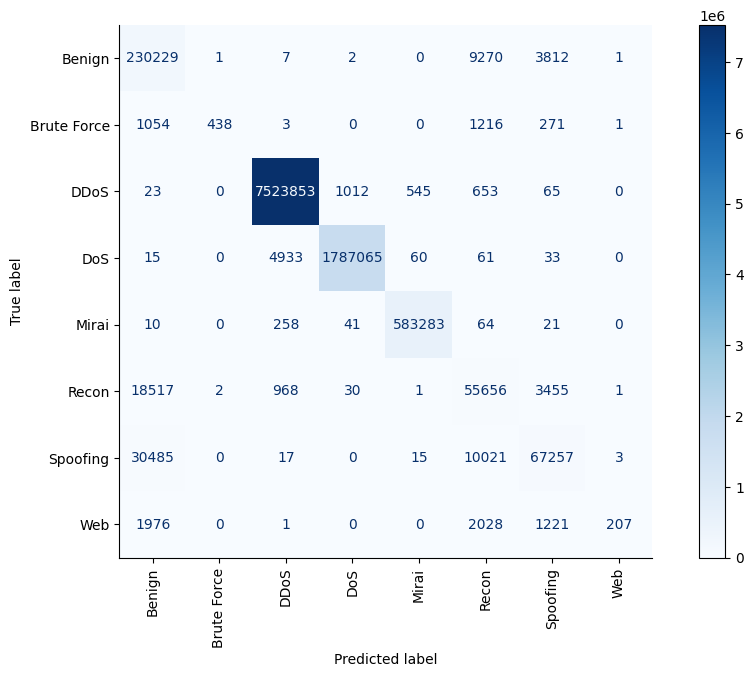

In [6]:
paper_confusion_matrix = pd.DataFrame.from_dict({
    'Benign': [230229,1,7,2,0,9270,3812,1],
    'Brute Force': [1054,438,3,0,0,1216,271,1],
    'DDoS': [23,0,7523853,1012,545,653,65,0],
    'DoS': [15,0,4933,1787065,60,61,33,0],
    'Mirai': [10,0,258,41,583283,64,21,0],
    'Recon': [18517,2,968,30,1,55656,3455,1],
    'Spoofing': [30485,0,17,0,15,10021,67257,3],
    'Web': [1976,0,1,0,0,2028,1221,207],
}, orient='index')

model_utils.show_metrics(
    paper_confusion_matrix.values,
    labels=paper_confusion_matrix.index
)

In [11]:
display(HTML(f"""
<p>
    Interesting to notice that in the paper, the authors mention that they have used a <strong>80/20 split</strong>,
    but based on the length of the dataset released and the absolute values in the Confusion Matrix, 
    we see a slightly different distribution, with the Test data having 
    <strong>{paper_confusion_matrix.sum().sum() / len(df):.2%}</strong> of the data.
</p>
"""))

## Baseline - Random Forest

In [6]:
%%time

baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=n_jobs, random_state=seed))
])

X_train, X_test, y_train, y_test = model_utils.get_train_test_split(
    df_sample,
    target='general_label',
    train_frac=0.80
)

model_utils.train_model(
    baseline_model,
    X_train,
    y_train,
    save_name='baseline_random_forest'
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).
Execution time (Model fit): 0:14:34.386048
CPU times: user 3h 43min 43s, sys: 3min 38s, total: 3h 47min 21s
Wall time: 15min 19s


Execution time (Predict): 0:00:52.012250
              precision    recall  f1-score   support

      Benign      0.925     0.981     0.952    219545
  BruteForce      0.995     0.566     0.721      2656
        DDoS      1.000     1.000     1.000   6797400
         DoS      1.000     1.000     1.000   1617348
       Mirai      1.000     1.000     1.000    526792
       Recon      0.911     0.846     0.877     70864
    Spoofing      0.920     0.876     0.897     97575
         Web      0.979     0.459     0.625      5136

    accuracy                          0.997   9337316
   macro avg      0.966     0.841     0.884   9337316
weighted avg      0.997     0.997     0.997   9337316

CPU times: user 23min 36s, sys: 34.5 s, total: 24min 11s
Wall time: 21min 7s


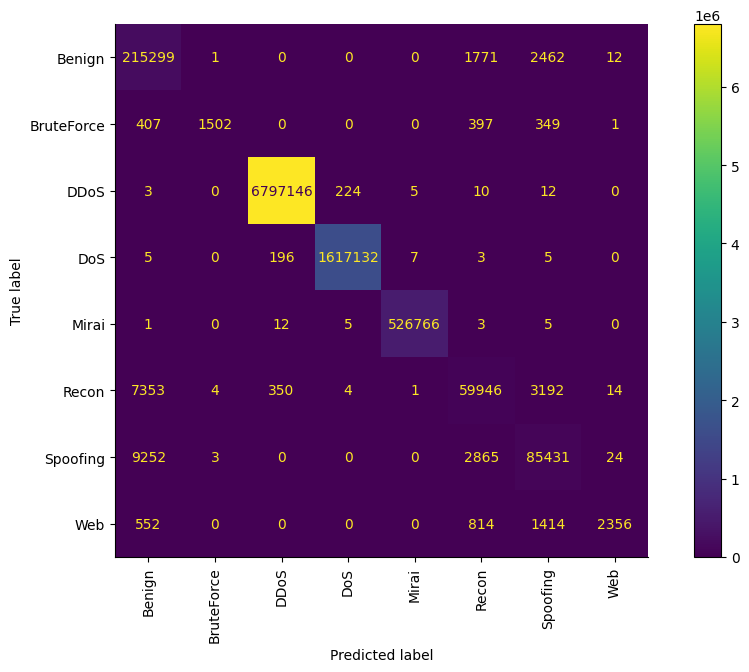

In [10]:
%%time
model_utils.evaluate_model(baseline_model, X_test, y_test)

# Multi-Stage Model

In [9]:
%%time

multi_stage_model = MultiStageClassifier(
    stages=[
        ModelStage(
            model=RandomForestClassifier(class_weight='balanced', max_features=9, n_jobs=n_jobs, random_state=seed),
            labels={'DDoS', 'DoS', 'Mirai'}
        ),
        ModelStage(
            model=RandomForestClassifier(max_features=10, n_jobs=n_jobs, random_state=seed),
            labels={'Spoofing', 'Recon', 'Web', 'BruteForce', 'Benign'}
        ),
    ]
)

X_train, X_test, y_train, y_test  = model_utils.get_train_test_split(
    df_refined_sample,
    target='general_label',
    train_frac=0.80
)

model_utils.train_model(
    multi_stage_model,
    X_train,
    y_train,
    save_name='baseline_random_forest'
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).
Execution time (Model fit): 0:18:10.792281
CPU times: user 5h 30min 38s, sys: 3min 13s, total: 5h 33min 52s
Wall time: 18min 50s


Execution time (Predict): 0:00:15.105300
              precision    recall  f1-score   support

      Benign      0.933     0.981     0.956    219545
  BruteForce      0.991     0.601     0.748      2656
        DDoS      1.000     1.000     1.000   6797400
         DoS      1.000     1.000     1.000   1617348
       Mirai      1.000     1.000     1.000    526792
       Recon      0.915     0.867     0.891     70864
    Spoofing      0.930     0.888     0.909     97575
         Web      0.984     0.571     0.723      5136

    accuracy                          0.997   9337316
   macro avg      0.969     0.864     0.903   9337316
weighted avg      0.997     0.997     0.997   9337316

CPU times: user 22min 16s, sys: 22.5 s, total: 22min 39s
Wall time: 20min 30s


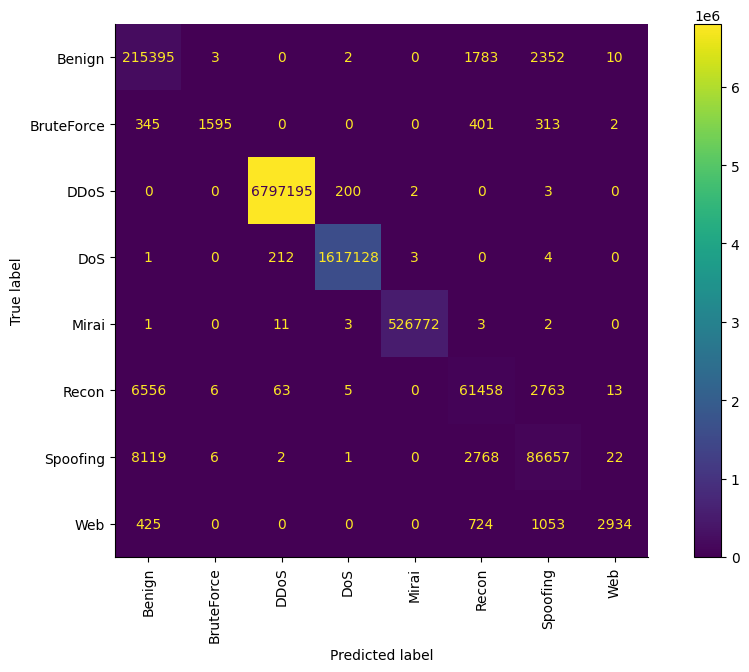

In [11]:
%%time
model_utils.evaluate_model(multi_stage_model, X_test, y_test)